# Convolutional Neural Network for Handwritten Persian Digits Recognition
by Majid Mortazavi, January 2018

Persian Digits Dataset generousnly provided by
- Dr. Hedieh Sajedi: <br>
    Handwriting recognition of digits, signs, and numerical strings in Persian: https://www.sciencedirect.com/science/article/pii/S0045790615004231
- Dr. Javad Sadri: <br>
    A novel comprehensive database for offline Persian handwriting recognition:
    https://www.sciencedirect.com/science/article/pii/S0031320316300097
- Dr. Karim Faez: <br>
http://ee.aut.ac.ir/autcms/labs/verticalPagesAjax/labHome.htm?id=3362052&depurl=electrical-engineering&lang=en&cid=59873573

In [1]:
import time
import math
import random
import glob

import numpy as np
import argparse

from random import shuffle
import random
import math

from PIL import Image
import tifffile as tiff

import os
import sys
import h5py
from glob import glob
import string
import cv2
from PIL import Image
from tqdm import tqdm_notebook
import shutil

from sklearn.model_selection import StratifiedShuffleSplit

from skimage import data
from skimage import color
from skimage import io
import skimage.transform

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import load_model
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD,Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback

# Allow image embeding in notebook
%matplotlib inline

/Users/majidmortazavi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_dir = '../digits/'
ext = [".bmp",".tif"]
classes = sorted(os.listdir(data_dir))
num_classes=len(classes)

## Read Images from Original Directory

In [3]:
def load_data(data_dir):
    
    '''
    A function that get all subdirectories 
    of data_dir. Each represents a label. Subsequently
    it reads all images into numpy array.
    '''
    
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(tuple(ext))]
        for f in file_names:
            images.append(cv2.imread(f,0).astype('float32'))
            labels.append(int(d))
    return images, labels

images, labels = load_data(data_dir)

## Construct Train/Dev/Test Splits

In [182]:
def organize_datasets_test(path_to_data, ratio=0.2):
    
    '''
    A function that takes the path to all images (with subdirectories for each class)
    and construct a train/dev/test directories with random sampling of all classes for training
    the convlutional neural network.
    The defualt split ratio is: train (90%)/dev(10%)/test(10%)
    '''
    
    for c in classes: 
        os.makedirs('../data/train/{0}/'.format(c))
        os.makedirs('../data/dev/{0}/'.format(c))
        os.makedirs('../data/test/{0}/'.format(c))
        
    for i in classes:  
        files=os.listdir(os.path.join(path_to_data, i))
        shuffle(files)
        
        n = int(len(files) * ratio)   
        m=int(n/2)
        
        test, dev, train = files[:m],files[m:n], files[n:]
        
        for filename in test:
            shutil.copy2(os.path.join(path_to_data,i,filename), os.path.join('..', 'data', 'test', i))
        for filename in dev:
            shutil.copy2(os.path.join(path_to_data,i,filename), os.path.join('..', 'data', 'dev', i))
        for filename in train:
            shutil.copy2(os.path.join(path_to_data,i,filename),os.path.join('..', 'data', 'train', i))
          
    print('Train, Dev, and Test Directories Constructed!')

In [183]:
organize_datasets_test(path_to_data=data_dir,ratio=0.2)

Train, Dev, and Test Directories Constructed!


## Display Images and Lables from Each Class (based on original directory)

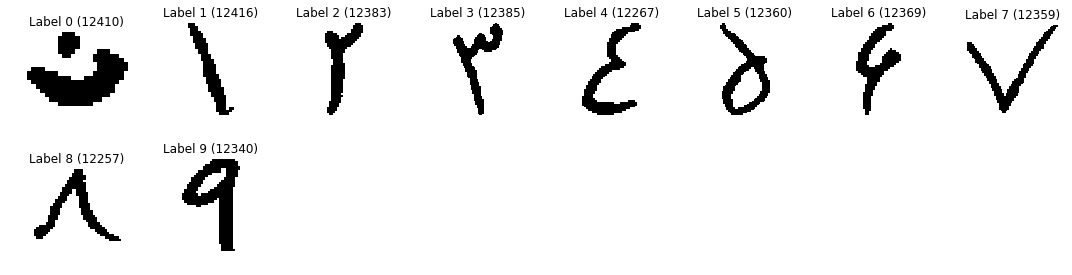

In [4]:
def display_images_and_labels(images, labels):
    
    """Display the first image of each label."""
    
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image, cmap='Greys_r')
    plt.tight_layout()

display_images_and_labels(images, labels)

## Display 24 Random Images from Same Class (based on original directory)

In [8]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image, cmap='Greys_r')
    plt.tight_layout()

## Digit 0 Samples

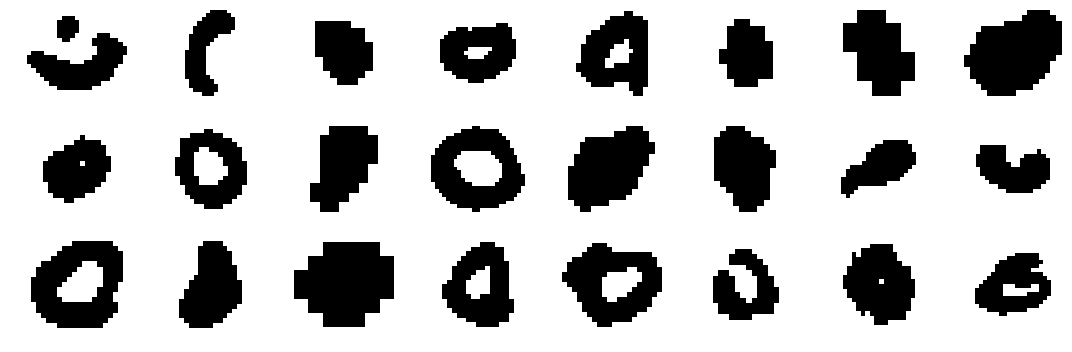

In [13]:
#Digit 0
display_label_images(images, 0)

## Digit 3 Samples

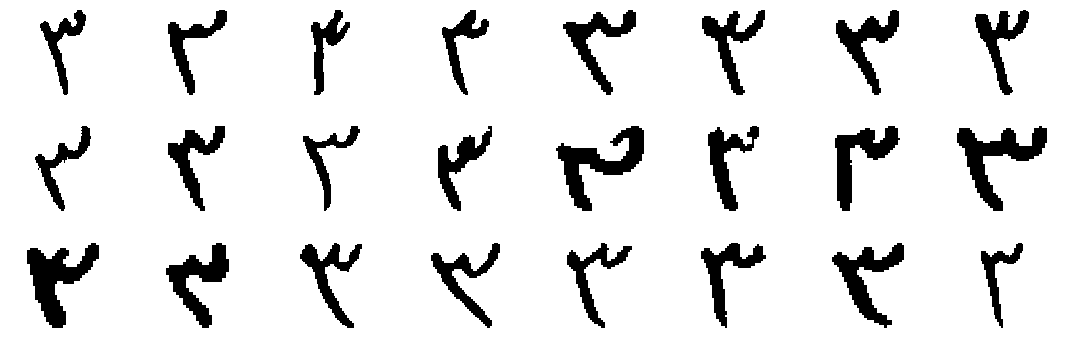

In [14]:
#Digit 3
display_label_images(images, 3)

## Digit 4 Samples

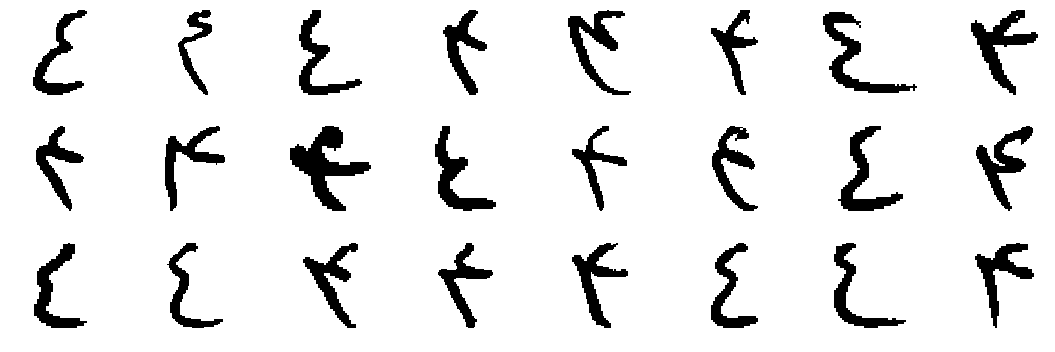

In [10]:
# Digit 4
display_label_images(images, 4)

## Digit 5 Samples

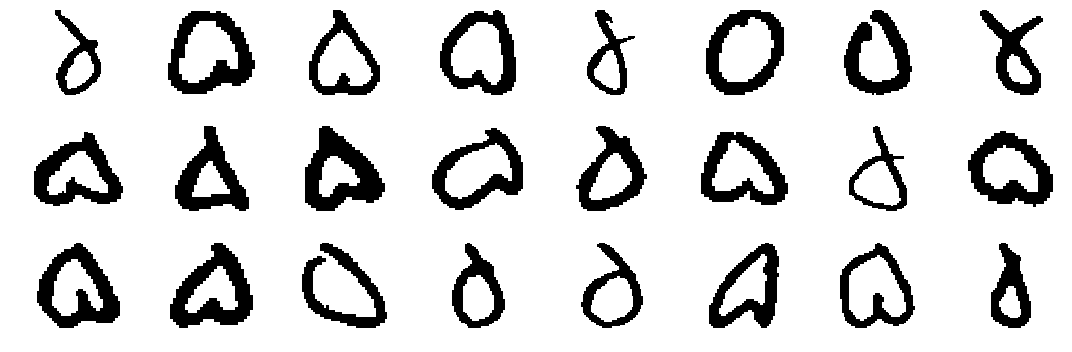

In [11]:
# Digit 5
display_label_images(images, 5)

## Digit 8 Samples

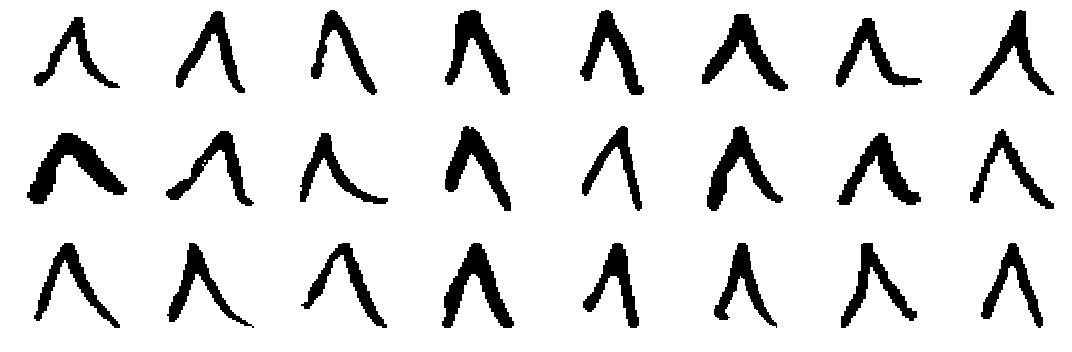

In [12]:
# Digit 8
display_label_images(images, 8)

## Generating Images for Batch Feeding to Keras Model

In [12]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                    #shear_range=0.2,
                                    #zoom_range=0.2,
                                    #horizontal_flip=True
                                    )
val_datagen = ImageDataGenerator(rescale=1/255.)

In [13]:
batch_size=128
train_generator = train_datagen.flow_from_directory(
        '../data/train/',
        target_size=(32, 32),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        '../data/dev/',
        target_size=(32, 32),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 98840 images belonging to 10 classes.
Found 12356 images belonging to 10 classes.


## Build Convlutional Neural Network Keras Model

In [14]:
lrate = 0.025
epochs = 40
decay = lrate/epochs

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(32, 32,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

#adm = Adam(lr=lrate, decay=decay)
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 64)          0         
__________

## The Model Architecture

![Image of Yaktocat](https://github.com/ahmedbesbes/Understanding-deep-Convolutional-Neural-Networks-with-a-practical-use-case-in-Tensorflow-and-Keras/raw/1a36392a502e27c15fd5e8da928e26b96af2e725/images/model.png)

## Callback for loss logging per epoch

In [16]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

## Callback for early stopping the training
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

## Training the Model

In [17]:
fitted_model = model.fit_generator(
        train_generator,
       
    steps_per_epoch= int(train_generator.n/train_generator.batch_size),
        validation_data=validation_generator,
        epochs=epochs,
        validation_steps= int(validation_generator.n/validation_generator.batch_size),
        callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), early_stopping, history],verbose=0)

## Learning Curves: Loss vs. Epochs

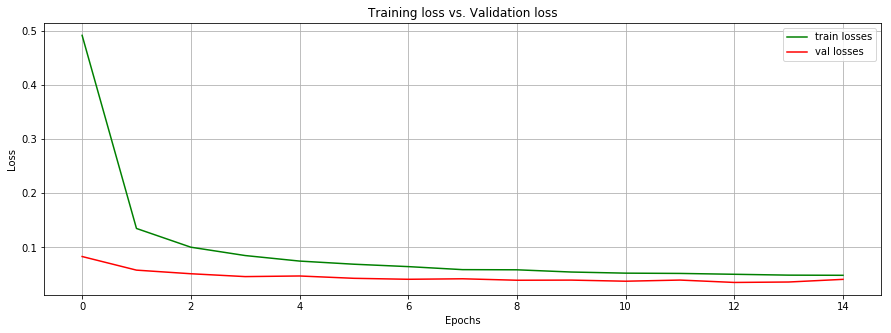

In [18]:
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Learning Curves: Accuracy vs. Epochs

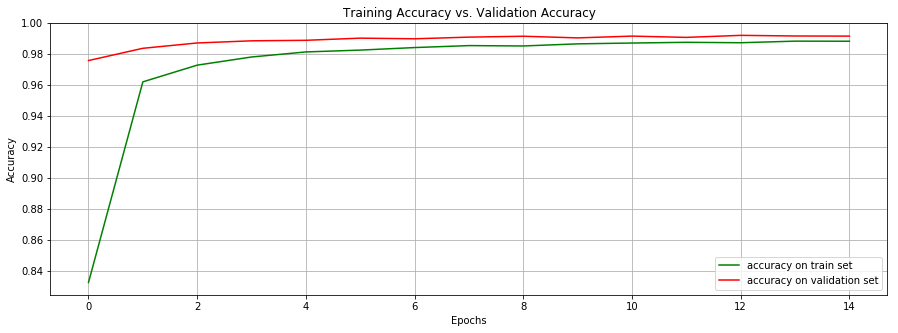

In [78]:
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['acc'], 'g', label="accuracy on train set")
plt.plot(fitted_model.history['val_acc'], 'r', label="accuracy on validation set")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Load Test Images

In [20]:
def load_test_image(data_test_dir):

    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    
        # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) 
                      if f.endswith(tuple(ext))]
        for f in file_names:
            image=cv2.imread(f,0).astype('float32')
            image=skimage.transform.resize(image/255., (32, 32))
            images.append(image)
            labels.append(int(d))
            
            #img = image.load_img(f, target_size=(32, 32))
            #img_tensor = image.img_to_array(img)                    # (height, width, channels)
            #img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
            #img_tensor /= 255.                   
            #images.append(img_tensor)
            #labels.append(int(d))
            
    return images, labels

In [21]:
test_images, test_labels= load_test_image(data_test_dir="../data/test/")

/Users/majidmortazavi/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## Check Prediction on a Randomly Sampled Imgages from Each Class

In [79]:
sample_indexes = random.sample(range(len(test_images)), 10)
sample_images = [test_images[i] for i in sample_indexes]
sample_labels = [test_labels[i] for i in sample_indexes]

predicted=[]

for i in range(len(sample_images)):
    pred=model.predict_classes(sample_images[i].reshape(1,32,32,1))
    predicted.append(int(pred))

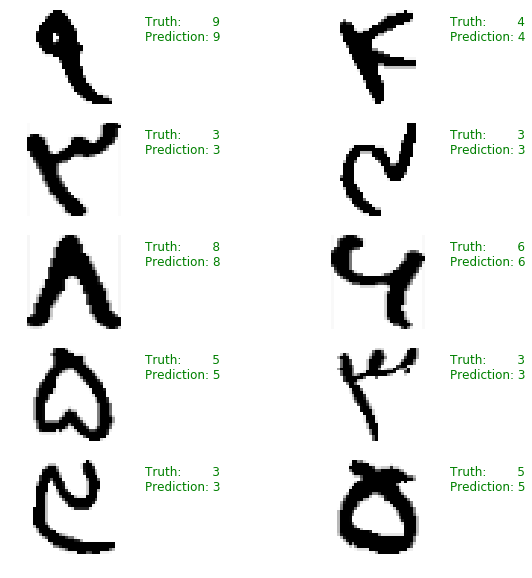

In [80]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i], cmap='Greys_r')

## Overal Accuracy on Test Images

In [27]:
# Run predictions against the full test set.
pred_test=[]

for i in range(len(test_images)):
    pred=model.predict_classes(test_images[i].reshape(1,32,32,1))
    pred_test.append(int(pred))

In [28]:
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, pred_test)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.994


## Full Classification Report

In [29]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, pred_test, target_names=classes))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99     12410
          1       0.98      1.00      0.99     12416
          2       0.99      0.99      0.99     12383
          3       0.99      0.99      0.99     12385
          4       1.00      0.99      0.99     12267
          5       0.99      1.00      0.99     12360
          6       1.00      0.99      0.99     12369
          7       1.00      1.00      1.00     12359
          8       1.00      1.00      1.00     12257
          9       1.00      0.99      1.00     12340

avg / total       0.99      0.99      0.99    123546



## Full Confusion Matrix

In [98]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [95]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, pred_test)
np.set_printoptions(precision=2)

Confusion matrix, without normalization


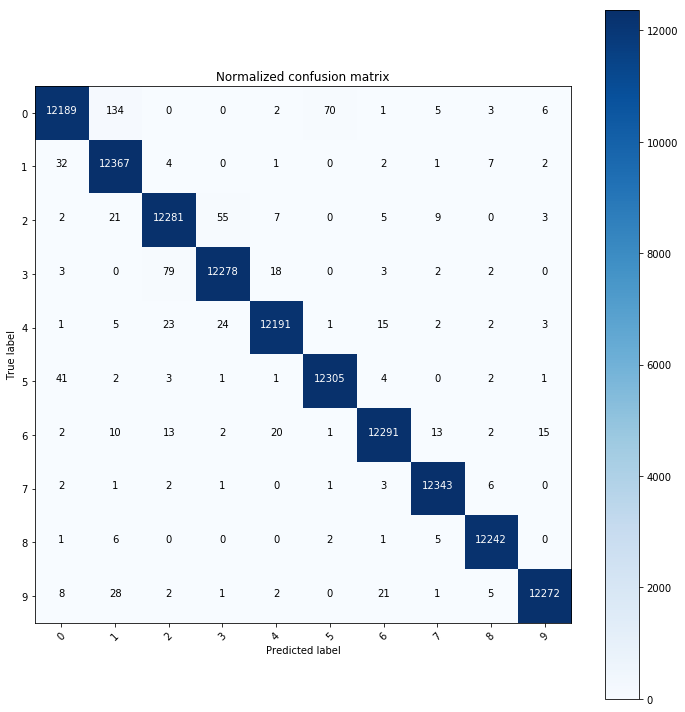

In [99]:
# Plot normalized confusion matrix
fig = plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=False,
                      title='Normalized confusion matrix');

plt.tight_layout();

## Save Keras Model (.h5) for Future Prediction

In [36]:
# save the model to disk
filename = 'finalized_cnn_model_persian_digits.h5'
model.save(filename)

# load the model for prediction
finalized_loaded_model = load_model(filename)

## Testing the Pretrained Model for Prediction

Predicted Digit is:[6]
Actual Digit is:


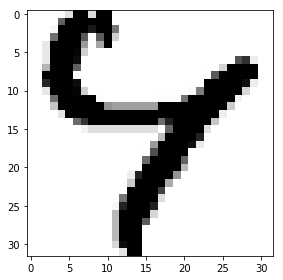

In [59]:
#for i in range(len(sample_images)):
test_image_index=45309
print('Predicted Digit is:{}'.format(finalized_loaded_model.predict_classes(test_images[test_image_index].reshape(1,32,32,1))))
print('Actual Digit is:')
plt.imshow(test_images[test_image_index], cmap='Greys_r')
plt.tight_layout()